In [1]:
import scSpace
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import math
import torch
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
sc_data_dir = '~/workspace/scSpace/data/[3]mouse_cortex_sc/original_data/starmap_sc_data.csv'
sc_meta_dir = '~/workspace/scSpace/data/[3]mouse_cortex_sc/original_data/starmap_sc_meta.csv'
st_data_dir = '~/workspace/scSpace/data/[3]mouse_cortex_sc/original_data/starmap_st_data.csv'
st_meta_dir = '~/workspace/scSpace/data/[3]mouse_cortex_sc/original_data/starmap_st_meta.csv'
sc_obj, st_obj = scSpace.load_data(sc_data_path=sc_data_dir, sc_meta_path=sc_meta_dir, 
                                   st_data_path=st_data_dir, st_meta_path=st_meta_dir,
                                   spatial_key = ['X', 'Y'])

Loading data...
Data have been loaded.


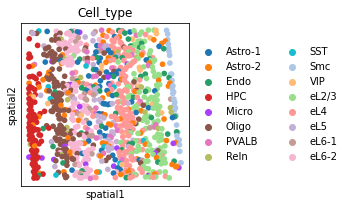

In [3]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(st_obj, basis="spatial", color="Cell_type")

In [4]:
sc_obj_hvg, st_obj_hvg = scSpace.preporcess(sc_adata=sc_obj, st_adata=st_obj, st_type='image', n_features=sc_obj.shape[1], normalize=True, select_hvg='union')

Data have been pre-processed.


In [5]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    
setup_seed(123)


import time
#记录开始时间
starttime = time.time()

sc_obj_hvg, st_obj_hvg = scSpace.construct_pseudo_space(
    sc_adata=sc_obj_hvg,
    st_adata=st_obj_hvg,
    batch_size=16,
    activation='sigmoid',
    lr=0.1,
    epoch_num=1000,
    log_epoch=1000)

endtime = time.time()
print(endtime - starttime)

Beginning Transfer Component Analysis...
Transfer Component Analysis done.
Beginning training encoder for source domain...


100%|██████████| 1000/1000 [00:51<00:00, 19.36it/s]

Epoch [1000/1000]: Batch loss=50882.8359375
Encoder for source domain training finished.
57.420013427734375


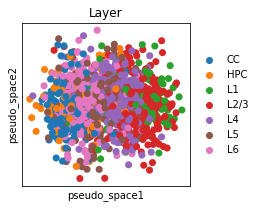

In [6]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(sc_obj_hvg, basis="pseudo_space", color="Layer", s=200)

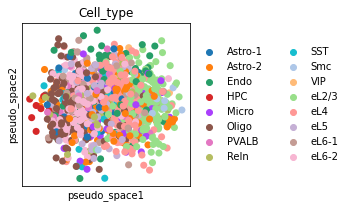

In [7]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(sc_obj_hvg, basis="pseudo_space", color="Cell_type", s=200)

In [8]:
from scipy.stats import pearsonr
pseudo_dist = scSpace.cal_dist(sc_obj_hvg.obsm['pseudo_space'])
real_dist = scSpace.cal_dist(np.array(sc_obj_hvg.obs[['X', 'Y']]))
pearson = round(pearsonr(pseudo_dist, real_dist)[0], 3)
print('PCC = ', pearson)

100%|██████████| 1207/1207 [00:01<00:00, 698.84it/s] 

PCC =  0.53


In [9]:
pd.DataFrame(sc_obj_hvg.obsm['pseudo_space']).to_csv('~/workspace/scSpace/data/[2]mouse_cortex_starmap/result/pseudo_space_starmap.csv')